In [1]:
import os
import time

import numpy as np
import scipy as sp
import bottleneck as bn

import math
import random

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
# randomize parameters 
N = 1000
M = 20

# smoothness of the sensitivity
std_dev = 0.02

# coupon's face value limits
bj_min = 0.6   
bj_max = 0.6 + (M-1) * 0.1

bj = np.linspace(bj_min, bj_max, M)

# sensitivity limits
pij_low_min = 0.0
pij_low_max = 0.8

pij_hig_min = 0.2
pij_hig_max = 0.99

In [3]:
def linear_fun(x, x1, y1, x2, y2):
    """
    linear function (x1, y1) and (x2, y2)
    """
    slope = (y2 - y1) / (x2 - x1)

    return slope * (x - x1) + y1

In [4]:
def log_fun(x, x1, y1, x2, y2):
    """
    logarithmic function (x1, y1) and (x2, y2)
    """
    a = (y2 - y1) / (math.log(x2) - math.log(x1))
    b = y1 - a * math.log(x1)

    return a * np.log(x) + b

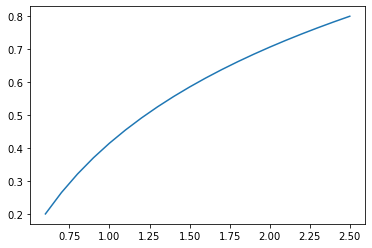

In [6]:
p = log_fun(bj, bj_min, 0.2, bj_max, 0.8)

plt.plot(bj, p)

In [7]:
def mono_fun(x, x1, y1, x2, y2):
    """
    construct a monotonoically increaseing function
    between (x1, y1) and (x2, y2)
    """
    funs = {
        "linear_fun": linear_fun,
        "log_fun": log_fun
    }

    rnd_name = random.choice(list(funs.keys()))
    rnd_fun = funs[rnd_name]

    return rnd_fun(x, x1, y1, x2, y2)

In [8]:
def noiser(x, n, std_dev):
    """
    Add the noise to the function.
    """
    return x + np.random.normal(0.0, std_dev, n)
    


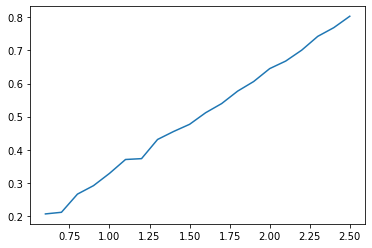

In [9]:
pij = mono_fun(bj, bj_min, 0.2, bj_max, 0.8)

pij = noiser(pij,M, 0.01)
plt.plot(bj, pij)
plt.show()

In [10]:
pij = []

std_dev = 0.02

for i in range(N):

    pij_low = np.random.uniform(pij_low_min, pij_low_max)
    a = max(pij_low,pij_hig_min)
    pij_hig = np.random.uniform(a, max(pij_hig_max,a))
    pij_one = mono_fun(bj, bj_min, pij_low, bj_max, pij_hig)
    pij_one = noiser(pij_one, M, std_dev)

    pij.append(pij_one)

pij = np.array(pij)


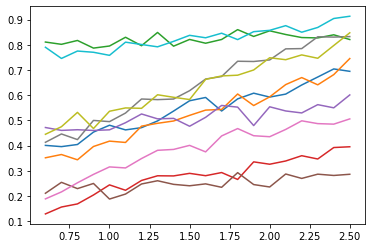

In [12]:
nplots = np.random.randint(0, N, 10)
for i in range(len(nplots)):
    plt.plot(bj, pij[nplots[i]])

plt.show()


In [13]:
def func(lamb, pij, sj, N):
    """Lagrangian function
    """
    varphi = pij - lamb
    # partition, Partition array so that the 
    # first 3 elements (indices 0, 1, 2) are the 
    # smallest 3 elements (note, as in this example, 
    # that the smallest 3 elements may not be sorted):
    varphi = -bn.partition(-varphi, 1, -1)[:, 0]
    return np.sum(varphi) * N * np.sum(lamb * sj)

In [14]:
aij = np.array([[3, 2, 1], [4, 5, 6], [8, 7, 9]])
lamb = np.array([1, 2, 3])

cij = aij - lamb

In [ ]:
-bn.partition(-aij, 1, -1)[:, 0]

array([3, 6, 9])

In [ ]:
bn.partition(aij, 2, -1)

array([[1, 2, 3],
       [4, 5, 6],
       [8, 7, 9]])

In [24]:
lamb0 = np.random.rand(M)

In [25]:
sj = np.random.rand(M)
sj = sj/np.sum(sj) + 0.01

In [ ]:
func(lamb0, pij, sj, N)

403624.6519642778

In [ ]:
varphi = pij - lamb0

In [ ]:
bn.argpartition(-varphi, 1, -1)

array([[17, 13,  5, ..., 19, 18,  1],
       [13, 17, 16, ...,  0, 18,  1],
       [17, 13, 16, ...,  0, 18,  1],
       ...,
       [17, 13, 19, ...,  2,  0,  1],
       [17, 13, 12, ..., 19, 18,  1],
       [17, 13, 12, ...,  0, 18,  1]], dtype=int64)

In [15]:
def dfunc(lamb, pij, sj, N):
    """derivative of Lagrangian
    """
    x = np.zeros((N, M))
    varphi = pij - lamb
    varphi_idx = bn.argpartition(-varphi, 1, -1)
    for i in range(N):
        for j in range(1):
            x[i, varphi_idx[i, j]] = 1
    return -np.sum(x, axis=0) + sj * N

In [ ]:
dfunc(lamb0, pij, sj, N)

array([  85.36958699,   45.02390998,   35.69104888,   54.54222049,
         29.4742715 ,   28.18531911,   53.11076335,   96.76602285,
         30.53097484,   63.1258893 ,   35.11075112,   98.97307395,
         11.18697566,  -31.83045963,  100.21735793,   84.09443716,
        120.10667387, -864.39531259,   83.43680955,   41.27968567])

In [16]:
def objective(pij, x):
    """Find the value of the objective function
    given the decision variables"""
    return np.sum(pij * x)

In [33]:
def objective_lamb(lamb, pij):
    """Find the value of the objective function
    given the Lagrangian multipiliers"""
    x = np.zeros((N, M))
    varphi = pij - lamb
    varphi_idx = bn.argpartition(-varphi, 1, -1)
    for i in range(N):
        for j in range(1):
            x[i, varphi_idx[i,j]] = 1
    return np.sum(pij * x)

In [18]:
# Check whether satisfies the constraints or not.
def checkConstraint(lamb, pij, sj, N):
    """check"""
    x = np.zeros((N, M))
    varphi = pij - lamb
    varphi_idx = bn.argpartition(-varphi, 1, -1)
    for i in range(N):
        for j in range(1):
            x[i, varphi_idx[i,j]] = 1
    return np.sum(x, axis = 0) - sj*N

In [26]:
def adam(theta0, pij, sj, N, verbose = True):
    """
    """
    if verbose:
        start = time.time()
    
    alpha, beta1, beta2, eps = 0.001, 0.9, 0.999, 1e-8
    beta1powert, beta2powert = 1.0, 1.0
    
    nitermax = 10000
    niter = 0
    
    theta_old = theta0 
    ndim = len(theta0)
    mold = np.zeros(ndim)
    vold = np.zeros(ndim)
    
    tolx = 1e-4
    tolf = 1e-4
    
    fold = func(theta0, pij, sj, N)
    
    while niter < nitermax:
        
        if niter % 100 == 0:
            print("iteration: {0}".format(niter))
        
        niter += 1
        
        g = dfunc(theta_old, pij, sj, N)
        mnew = beta1 * mold + (1-beta1)*g
        vnew = beta2 * vold + (1-beta2)*g*g
        
        beta1powert *= beta1
        beta2powert *= beta2
        
        mhat = mnew/(1 - beta1powert)
        vhat = vnew/(1 - beta2powert)
        
        theta_new = theta_old - alpha * mhat / (np.sqrt(vhat) + eps)
        
        if niter % 100 == 0:
            print("theta_old: {0}".format(theta_old))
            print("theta_new: {0}".format(theta_new))
        
        theta_new[theta_new < 0.0] = 0.0
        
        if np.sqrt(np.inner(theta_new - theta_old, theta_new - theta_old)) < tolx:

            if verbose:
                end = time.time()
                print("Running time: {}\n".format(end - start))
            return theta_new
        
        if niter%100 == 0:
            print("fold : {0}".format(fold))
        fnew = func(theta_new, pij, sj, N)
        if niter % 100 == 0:
            print("fnew : {0}".format(fnew))
        if np.abs(fold - fnew) < tolf:
            print("Here")
            if verbose:
                end = time.time()
                print("Running time: {}\n".format(end - start))
            return theta_new
        
        theta_old = theta_new
        fold = fnew
        mold = mnew
        vold = vnew
        
                
        if verbose and niter%100 == 0:
            print("{0}th iteration \t theta: {1} obj func: {2} \t grad: {3}"
                  .format(niter, theta_old, fold, g))
            
    print("EXCEED THE MAXIMUM ITERATION NUMBERS!")
    if verbose:
        end = time.time()
        print("Running time : {}\n".format(end - start))
        
    return theta_new

In [27]:
res = adam(lamb0, pij, sj, N, verbose = True)

iteration: 0
theta_old: [0.18421383 0.70382616 0.21298224 0.90047983 0.82120036 0.39747286
 0.10777839 0.3368926  0.7318751  0.11102096 0.37546116 0.14011276
 0.89524603 0.76048272 0.58639934 0.19720109 0.36790511 0.40387159
 0.24496579 0.26120666]
theta_new: [0.18321383 0.70282616 0.21198224 0.89947983 0.82020036 0.39647286
 0.10844867 0.3358926  0.7308751  0.11179683 0.37446116 0.14073504
 0.89424603 0.75948272 0.58539934 0.19747402 0.36690511 0.40287159
 0.24557708 0.26189331]
fold : 251077.28452952465
fnew : 250458.6595482859
100th iteration 	 theta: [0.18321383 0.70282616 0.21198224 0.89947983 0.82020036 0.39647286
 0.10844867 0.3358926  0.7308751  0.11179683 0.37446116 0.14073504
 0.89424603 0.75948272 0.58539934 0.19747402 0.36690511 0.40287159
 0.24557708 0.26189331] obj func: 250458.6595482859 	 grad: [  69.70748052   39.68407931   72.12763138   28.01359324   54.33111334
   79.49198215  -23.5699279    80.30620962   69.8899844  -279.25743036
   33.6095988   -81.89655871   72.80

In [29]:
import mip

I = range(N)
V = range(M)

model = mip.Model()

x = [[model.add_var(var_type = mip.BINARY) for j in V] for i in I]

model.objective = mip.maximize(mip.xsum(pij[i][j] * x[i][j] for i in I for j in V))

# local constraints, only 3 benefits recommended for 
for i in I:
    model += mip.xsum(x[i][j] for j in V) == 1
    
# global constraints, the coupons are limited by numbers
for j in V:
    model += mip.xsum(x[i][j] for i in I) <= sj[j] * N

In [30]:
model.optimize()

<OptimizationStatus.OPTIMAL: 0>

In [31]:
model.objective_value

667.7966775824501

In [34]:
objective_lamb(res, pij)

667.671297977753